<a href="https://colab.research.google.com/github/azzy13/gnn_study/blob/main/GNN_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Simple Graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()

In [ ]:
G.add_nodes_from([2, 3])

In [ ]:
edges = [(2,1),(2,2),(3,2),(4,3),(6,4),(7,5),(14,5)]
G.add_edges_from(edges)

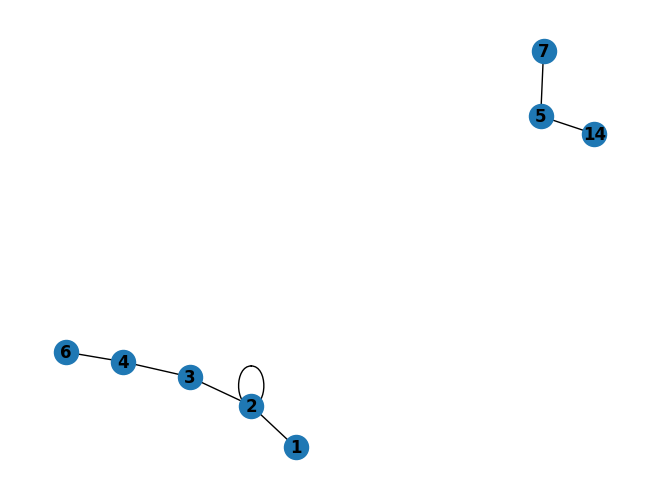

In [ ]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

2. Node classification using Pytorch

In [2]:
!pip install dgl
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 10.8 MB/s eta 0:00:00


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
print(g)

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})


In [3]:
from dgl.nn import GraphConv
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [4]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.946, val acc: 0.178 (best 0.178), test acc: 0.175 (best 0.175)
In epoch 5, loss: 1.888, val acc: 0.676 (best 0.676), test acc: 0.685 (best 0.685)
In epoch 10, loss: 1.803, val acc: 0.634 (best 0.680), test acc: 0.653 (best 0.693)
In epoch 15, loss: 1.693, val acc: 0.658 (best 0.680), test acc: 0.674 (best 0.693)
In epoch 20, loss: 1.558, val acc: 0.698 (best 0.698), test acc: 0.696 (best 0.696)
In epoch 25, loss: 1.402, val acc: 0.712 (best 0.712), test acc: 0.708 (best 0.708)
In epoch 30, loss: 1.232, val acc: 0.714 (best 0.714), test acc: 0.718 (best 0.717)
In epoch 35, loss: 1.056, val acc: 0.732 (best 0.734), test acc: 0.732 (best 0.731)
In epoch 40, loss: 0.886, val acc: 0.738 (best 0.738), test acc: 0.738 (best 0.733)
In epoch 45, loss: 0.729, val acc: 0.742 (best 0.742), test acc: 0.745 (best 0.741)
In epoch 50, loss: 0.593, val acc: 0.742 (best 0.750), test acc: 0.744 (best 0.747)
In epoch 55, loss: 0.478, val acc: 0.748 (best 0.750), test acc: 0.753 (best 0